In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import spacy

import torch

import torchtext
from torchtext.data import Field, BPTTIterator
from torchtext.datasets import WikiText2

SEED = 42
np.random.seed(SEED)

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

 # Delelop language model, which generates texts from wikipedia.

## Try to use together (sentencepiece or tokenizers), torchtext.datasets, and torchtext.data.BPTTIterator

In [3]:
!pip install tokenizers

In [0]:
import tokenizers

In [0]:
from spacy.lang.en import English
# Load English tokenizer, tagger, parser, NER and word vectors
nlp = English()

# Create the pipeline 'sentencizer' component
sbd = nlp.create_pipe('sentencizer')

# Add the component to the pipeline
nlp.add_pipe(sbd)

def senttokenizer(text):
    nlp.max_length = len(text) + 1
    return [i for i in nlp(text).sents]

In [6]:
senttokenizer('Sentense. Another sentence.')

[Sentense., Another sentence.]

In [7]:
WikiText2.download('.')

'./wikitext-2/wikitext-2'

In [0]:
w_dir = './wikitext-2/wikitext-2'

In [0]:
from os import path

with open(path.join(w_dir, 'wiki.valid.tokens'), 'r') as f:
    val = f.read()
with open(path.join(w_dir, 'wiki.train.tokens'), 'r') as f:
    train = f.read()
with open(path.join(w_dir, 'wiki.test.tokens'), 'r') as f:
    test = f.read()

In [10]:
print(train[:2000])

 
 = Valkyria Chronicles III = 
 
 Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . <unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . 
 The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more <unk> for series newcomers . Char

In [0]:
raw = [val, train, test]
prepared = []
for text in raw:
    sentences = senttokenizer(text)
    prepared_text = ['<start> {} <end>'.format(sent) for sent in sentences if sent]
    prepared.append(prepared_text)

In [12]:
prepared[0][:5]

['<start>  \n = Homarus gammarus = \n \n Homarus gammarus , known as the European lobster or common lobster , is a species of <unk> lobster from the eastern Atlantic Ocean , Mediterranean Sea and parts of the Black Sea . <end>',
 '<start> It is closely related to the American lobster , H. americanus . <end>',
 '<start> It may grow to a length of 60 cm ( 24 in ) and a mass of 6 kilograms ( 13 lb ) , and bears a conspicuous pair of claws . <end>',
 '<start> In life , the lobsters are blue , only becoming " lobster red " on cooking . <end>',
 '<start> Mating occurs in the summer , producing eggs which are carried by the females for up to a year before hatching into <unk> larvae . <end>']

In [0]:
with open('training.txt', 'a', encoding='utf-8') as f:
    for text in prepared:
        f.write('\n'.join(text))
        f.write('\n')


In [0]:
BPEtokenizer = tokenizers.SentencePieceBPETokenizer()

In [0]:
BPEtokenizer.train('training.txt', special_tokens=['<start>', '<end>', '<unk>'], vocab_size=20000)

In [16]:
BPEtokenizer.encode("<start> Never know how much I hate you. <end> Never know how careless I can be lmaof").tokens

['<start>',
 '▁Never',
 '▁know',
 '▁how',
 '▁much',
 '▁I',
 '▁hate',
 '▁you',
 '.',
 '▁',
 '<end>',
 '▁Never',
 '▁know',
 '▁how',
 '▁car',
 'eless',
 '▁I',
 '▁can',
 '▁be',
 '▁l',
 'ma',
 'of']

In [0]:
def add_and_tokenize(text, tokenizer=BPEtokenizer):
    sentences = senttokenizer(text)
    prepared_text = ' '.join(['<start> {} <end>'.format(sent) for sent in sentences if sent])
    return tokenizer.encode(prepared_text).tokens

In [18]:
add_and_tokenize('How much it will take? I want to go home')

['<start>',
 '▁How',
 '▁much',
 '▁it',
 '▁will',
 '▁take',
 '?',
 '▁',
 '<end>',
 '▁',
 '<start>',
 '▁I',
 '▁want',
 '▁to',
 '▁go',
 '▁home',
 '▁',
 '<end>']

In [0]:
Field = Field(init_token='start', eos_token='end', lower=True, tokenize=add_and_tokenize, batch_first=True)

In [0]:
train, valid, test = WikiText2.splits(Field)

In [0]:
Field.build_vocab(train, valid, test, min_freq=5, )

In [0]:
tr_it, val_it, te_it = torchtext.data.BPTTIterator.splits((train, valid, test), batch_size=32, bptt_len=50, repeat=False,
    device=device)

## Autoregression RRN 

In [0]:
import torch.nn as nn

In [0]:
class AuRRNN(torch.nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(AuRRNN, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embed_size)
        
        self.rnn = nn.LSTM(input_size=embed_size,
                           hidden_size=hidden_size,
                           bidirectional=True,
                           batch_first=True,
                          )
        
        self.fc = nn.Linear(hidden_size * 2, vocab_size)
        
        self.init_weights()
        
    def init_weights(self):
        nn.init.uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, batch):
        try:
            x = batch.text.T
        except AttributeError:
            x = batch
        
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x.transpose(1,2)


In [0]:
from tqdm import tqdm, tqdm_notebook

In [0]:
def _train_epoch(model, iterator, optimizer, criterion, curr_epoch):

    model.train()
    train_losses = []
    running_loss = 0

    n_batches = len(iterator)
    iterator = tqdm_notebook(iterator, total=n_batches, desc='epoch {}'.format(curr_epoch), leave=True)

    for i, batch in enumerate(iterator):
        optimizer.zero_grad()

        pred = model(batch)
        loss = criterion(pred, batch.target.T)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        curr_loss = loss.data.cpu().detach().item()
        
        loss_smoothing = i / (i + 1)
        running_loss = loss_smoothing * running_loss + (1 - loss_smoothing) * curr_loss

        iterator.set_postfix(loss='%.5f' % running_loss)

    return running_loss, train_losses

def _test_epoch(model, iterator, criterion):
    model.eval()
    test_losses = []
    epoch_loss = 0

    n_batches = len(iterator)
    with torch.no_grad():
        for batch in iterator:
            pred = model(batch)
            loss = criterion(pred, batch.target.T)
            test_losses.append(loss.item())
            epoch_loss += loss.data.item()

    return (epoch_loss / n_batches), test_losses


def nn_train(model, train_iterator, valid_iterator, criterion, optimizer, n_epochs=100,
          scheduler=None, early_stopping=0):
    model = model.to(device)
    criterion = criterion.to(device)
    prev_loss = 100500
    es_epochs = 0
    best_epoch = None
    history = pd.DataFrame()
    epoch_train_losses = []
    epoch_valid_losses = []

    for epoch in range(n_epochs):
        train_loss, epoch_train_loss = _train_epoch(model, train_iterator, optimizer, criterion, epoch)
        valid_loss, epoch_valid_loss = _test_epoch(model, valid_iterator, criterion)

        epoch_train_losses += epoch_train_loss
        epoch_valid_losses += epoch_valid_loss

        print('validation loss %.5f' % valid_loss)

        record = {'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss}
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            if valid_loss > prev_loss:
                es_epochs += 1
            else:
                es_epochs = 0

            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print('Early stopping! best epoch: %d val %.5f' % (best_epoch['epoch'], best_epoch['valid_loss']))
                break

            prev_loss = min(prev_loss, valid_loss)
    return history, epoch_train_losses, epoch_valid_losses

In [0]:
# torch.cuda.empty_cache()

batch_size = 32

model = AuRRNN(vocab_size=len(Field.vocab.itos),
                embed_size=100,
                hidden_size=128,
               )

optimizer = torch.optim.Adam(model.parameters())
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True, cooldown=5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

# padding does not count into loss
criterion = nn.CrossEntropyLoss(ignore_index=1)

In [29]:
history, train_losses, valid_losses = nn_train(model, tr_it, val_it, criterion, optimizer, scheduler=scheduler, 
        n_epochs=10, early_stopping=5)


validation loss 2.50693



validation loss 1.38550



validation loss 0.79720



validation loss 0.48551



validation loss 0.33334



validation loss 0.25652



validation loss 0.21673



validation loss 0.19485



validation loss 0.18273



validation loss 0.17675


## Plot train and validation loss depending on the number of iterations of gradient decent

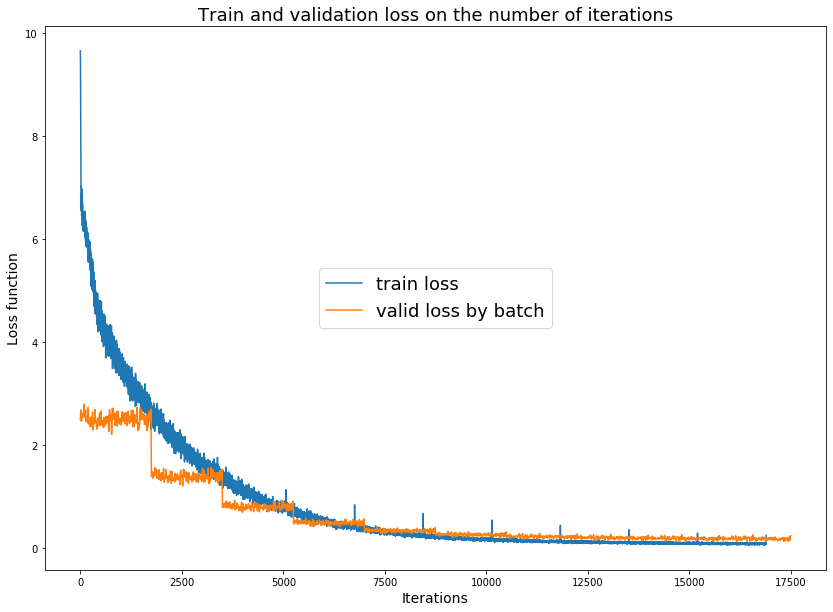

In [30]:
plt.figure(figsize=(14, 10))
plt.plot(range(len(train_losses)), train_losses, np.array(range(len(valid_losses)))*10, valid_losses)
plt.legend(('train loss', 'valid loss by batch'),
           loc='center', prop={'size': 18})
plt.title('Train and validation loss on the number of iterations', fontsize=18)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Loss function', fontsize=14)
plt.show()

# Text generation

In [0]:
model = model.cpu()

In [0]:
max_sent = 20

def decode_id(i):
    return Field.vocab.itos[i]

def encode_token(token):
    return Field.vocab.stoi[token]

def decode_sequence(seq):
    return [decode_id(i) for i in seq]

def make_sentence(tokens, start='<start>',  end='<end>'):
    tokens = [i for i in tokens if i not in [start, end]]
    sent = ''.join(tokens)
    sent = sent.replace('▁', ' ')
    return sent


In [0]:
def generate_sentence(model, activation, max_sentence=50, start_token='<start>', end_token='<end>'):
    stop = encode_token(end_token)
    start = encode_token(start_token)
    with torch.no_grad():
        token = start
        seq = [token]
        i = 0
        while i < max_sentence and token != stop:
            i += 1
            pred = model(torch.tensor([seq]))[:,:,-1]
            t = activation(pred)
            seq.append(t)

    return make_sentence(decode_sequence(seq))

In [0]:
def generate_example(model, activation, min_words=10, start='<start>'):
    candidate = generate_sentence(model, activation, start_token=start)
    a = len([i for i in candidate.split(' ') if i not in '.,?!:;)('])
    while a < min_words:
        candidate = generate_sentence(model, activation, start_token=start)
        a = len([i for i in candidate.split(' ') if i not in '.,?!:;)('])
    return 'Слов в примере: {}\nПример: {}'.format(a, candidate)


## Argmax

In [0]:
# Activation func: argmax
argmax = lambda x: torch.argmax(x).item()

In [165]:
argmax_example = generate_example(model, argmax, start='a')

print(argmax_example)

Слов в примере: 16
Пример: a ) , john <unk> , <unk> , <unk> ( <unk> ) , <unk> ) , <unk> ) , <unk> ) , <unk> ( <unk> ) = = = <eos>   <eos>   


Генерируется лажа :(

## Sampling from probabilty distribution with temperature

In [168]:
def temperature(logits, tau=1):

    logits = logits.detach()
    out = torch.exp(logits/tau)/torch.sum(torch.exp(logits/tau)) 
    out = out.squeeze()
    if np.sum(out.numpy()) != 1:
        return out.numpy()/np.sum(out.numpy())
    else:
        return out.numpy()


def sampling_temperature(logits, tau=1):
    probs = temperature(logits, tau=tau)
    return np.random.choice(len(probs), 1, p=probs)[0]

temperature_example = generate_example(model, sampling_temperature, start='a', min_words=40)

print(temperature_example)

Слов в примере: 40
Пример: a may have been edited by brooks are about them in washington while on morrison , several factors built of norse government .   alan watson in its original colonial was damaged over 400 million relationships .   the final threat may have low successful


## Top k sampling

In [0]:
def top_k(logits, k=0.1):
    logits = logits.detach().squeeze()
    argsorted = torch.argsort(logits, descending=True)

    last = int(np.floor(len(logits) * k))
    if last == 0:
        last = 1

    top_k_ids = argsorted[:last]
    top_k = logits[top_k_ids]
    return top_k, top_k_ids


def sampling_top_k(logits, k=0.2):
    top_k_logits, top_k_ids = top_k(logits, k=k)
    probs = temperature(top_k_logits)
    if len(top_k_ids) == 1:
        return top_k_ids.numpy()[0]
    return np.random.choice(top_k_ids.numpy(), 1, p=probs)[0]

In [177]:
topk_example = generate_example(model, sampling_top_k, start='i', min_words=12)
print(topk_example)

Слов в примере: 35
Пример: i nbroellardchese described as a small public american type , but as co @-@ rays , under wausiyator was so to the right of granite august of the request started in an attempt to containing 2003 . <eos> 
